In [1]:
import os
import time
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
# from torch import cdist
# import glob

In [2]:
from dotenv import load_dotenv
from databricks import sql
# from numba import jit

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.python.framework.errors_impl import InvalidArgumentError
import tensorflow as tf

/Users/dashtbozorgi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
from catboost import CatBoostRegressor
from hmmlearn import hmm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import umap
import math
# from statsmodels.tsa.arima.model import ARIMA

/Users/dashtbozorgi/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ROOT_DIR = Path().cwd()
while not ROOT_DIR.joinpath("data").exists():
    ROOT_DIR = ROOT_DIR.parent
os.chdir(ROOT_DIR)

In [6]:
# import EncoderFactory
# from DatasetManager import DatasetManager
from data import EncoderFactory
from data import DatasetManager

AMBR
CSL312
Astrazeneca
bpic2011_f1
bpic2011_f2
bpic2011_f3
bpic2011_f4


In [58]:
case_id_col = "Culture ID"
timestamp_col = "ECT"
work_day_col = "Working_Day"
target_col = "[mAb]"

In [110]:
df = pd.read_csv('data/processed/astrazeneca_preprocessed.csv')
df[case_id_col].nunique()

95

In [109]:
df[case_id_col].nunique()

48

In [10]:
df = df.sort_values(by=[case_id_col, work_day_col])

##############################################################################

In [11]:
df_normalized = df.copy()

In [111]:

# Assuming your data is stored in a DataFrame called 'data'
average_max_work_day = data.groupby(case_id_col)[work_day_col].max().mean()

print("Average Maximum work_day_col:", average_max_work_day)

Average Maximum work_day_col: 15.242105263157894


In [ ]:
# df_normalized = pd.read_csv('data/processed/databricks_preprocessed_forTiter_notNormalised.csv')

In [ ]:
# df_normalized.to_csv('data/processed/databricks_preprocessed_forTiter_normalised_7Jan25.csv', index=False)
df_normalized.to_csv('data/processed/databricks_preprocessed_forTiter_normalised_3Feb25.csv', index=False)

##############################################################################

In [12]:
df_normalized = pd.read_csv('data/processed/astrazeneca_preprocessed.csv')

In [13]:
features = [x for x in df_normalized.columns if (x != target_col) & (x != case_id_col) & (x != timestamp_col) & (x != work_day_col)]
print(features)  

['VCD', 'TCD', 'ACC', 'ACD', 'pH', '[Glutamine]', '[Glutamate]', 'EGN', 'ACV', '[Lactate] ', '[NH3]', 'Osmolality', '[Glucose]', 'CPDL', '[Na+]', '[K+]', '[HCO3-]', 'Temperature', 'pCO2', 'pO2', 'Culture Volume', 'Vol_original']


In [14]:
len(features)

22

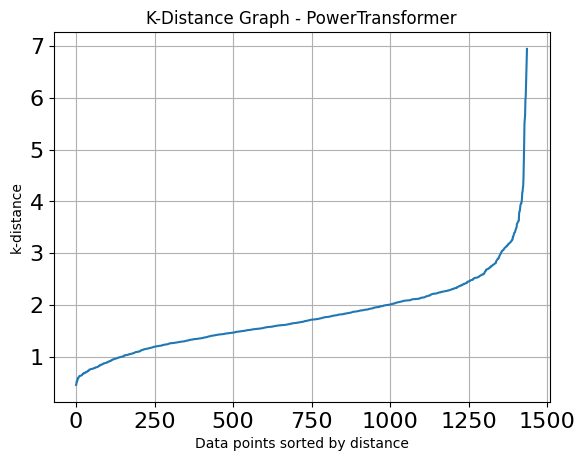

In [15]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PowerTransformer, Normalizer

# Sample data
data = df[features]  # Replace with your actual data
# scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = MaxAbsScaler()
scaler = PowerTransformer()
# scaler = Normalizer()
# scaler = TimeSeriesScalerMinMax()
X_scaled = scaler.fit_transform(data)

# Fit nearest neighbors
k = 5  # Choose k as min_samples for DBSCAN
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort and plot distances to the k-th nearest neighbor
distances = np.sort(distances[:, k-1])
plt.plot(distances)
plt.ylabel('k-distance')
plt.xlabel('Data points sorted by distance')
plt.title('K-Distance Graph - PowerTransformer')
# plt.rcParams['xtick.labelsize'] = 0.1
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True)
plt.show()

In [16]:
X_scaled = df_normalized[features]

In [17]:
# Dimensionality reduction with UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_scaled)
embedding.shape

(1437, 2)

In [18]:
reducer_ = umap.UMAP(random_state=12)
embedding_ = reducer.fit_transform(X_scaled)
embedding_.shape

(1437, 2)

In [19]:
import joblib

In [ ]:
joblib.dump(reducer, 'astra_reducer.pkl')

In [20]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

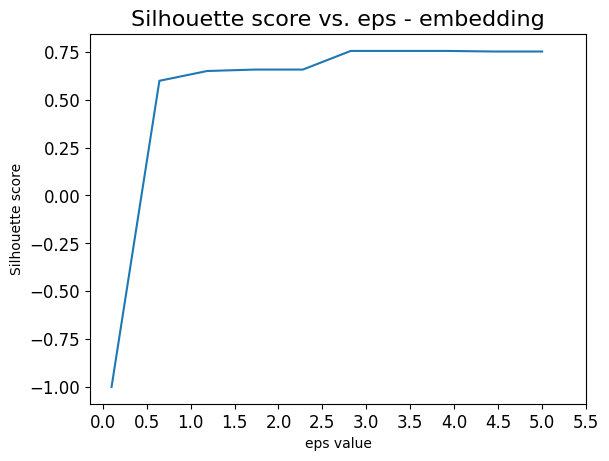

In [21]:
# Sample data
X_scaled = embedding_

# Define a range of eps values to test
eps_values = np.linspace(0.1, 5.0, 10)

# List to store the silhouette scores
silhouette_scores = []

# Compute silhouette scores for different eps values
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=20).fit(X_scaled)
    labels = db.labels_
    # Ignore the silhouette score if only one cluster or all points are noise
    if len(set(labels)) > 1:
        score = silhouette_score(X_scaled, labels)
        # score = calinski_harabasz_score(X_scaled, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # Invalid score

# Plot silhouette scores
plt.plot(eps_values, silhouette_scores)
# plt.ylabel('Silhouette Score')
plt.ylabel('Silhouette score')
plt.xlabel('eps value')
plt.xticks(np.arange(0, 6, step=0.5))
# plt.rcParams['xtick.labelsize'] = 0.7
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Silhouette score vs. eps - embedding', fontsize=16)
plt.show()

In [22]:
eps = 2
min_samples = 30
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
dbscan.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [23]:
pd.Series(dbscan.labels_).value_counts()

 1    429
 0    308
 3    234
 6    134
 2    111
 7     92
 4     64
 5     43
-1     22
Name: count, dtype: int64

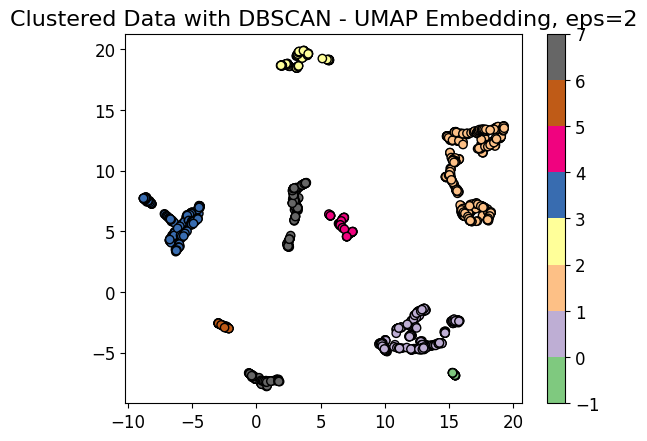

In [24]:
# Visualize the dbscan clustered data
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan.labels_, cmap='Accent', edgecolors='k')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=100, c='red', label='Centroids')
plt.title(f'Clustered Data with DBSCAN - UMAP Embedding, eps={eps}', fontsize=16)
# plt.xlabel("Lactate (g/L)")
# plt.ylabel("Glucose (g/L)")
plt.tick_params(axis='both', which='major', labelsize=12)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
# plt.legend()
plt.show()

In [25]:
df_normalized['Cluster'] = dbscan.labels_

In [26]:
import random

In [ ]:
def split_data(data, train_ratio=0.70, split="temporal", leave_out=[], seed=22):  
    # split into train and test using temporal split
    print(split)

    data[work_day_col] = data[work_day_col].astype(int)
    print(data[work_day_col].dtype)
    grouped = data.groupby(case_id_col)
    # start_timestamps = grouped[timestamp_col].min().reset_index()
    if split == "temporal":
        start_timestamps = start_timestamps.sort_values(timestamp_col, ascending=True, kind="mergesort")
        train_ids = list(start_timestamps[case_id_col])[:int(train_ratio*len(start_timestamps))]

    elif split == "temporal sim":
        # Calculate the number of elements to select
        num_elements = int(len(data[case_id_col].unique()) * train_ratio)
        train_ids = random.sample(list(data[case_id_col].unique()), num_elements)

    elif split == "random":
        np.random.seed(seed)
        start_timestamps = start_timestamps.reindex(np.random.permutation(start_timestamps.index))
        train_ids = list(start_timestamps[case_id_col])[:int(train_ratio*len(start_timestamps))]

    elif split == "loo":
        try:
            leave_id = str(leave_out[0])
            all_ids = list(data[case_id_col].unique())
            train_ids = all_ids
            train_ids.remove(leave_id)

        except IndexError:
            print("Leave out list is empty.")

    elif split == "lmo":
        try:
            all_ids = list(data[case_id_col].unique())
            train_ids = [id for id in all_ids if id not in leave_out]
            print(f"Train ids: {train_ids}")

        except IndexError:
            print("Leave out list is empty.")
            
    train = data[data[case_id_col].isin(train_ids)].sort_values(work_day_col, ascending=True, kind='mergesort')
    test = data[~data[case_id_col].isin(train_ids)].sort_values(work_day_col, ascending=True, kind='mergesort')

    return (train, test)

In [ ]:
def get_size_max_len(sequences):
    # Tokenize the words
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sequences)
    vocab_size = len(tokenizer.word_index) + 1

    # Convert words to sequences of integers
    sequences_int = tokenizer.texts_to_sequences(sequences)

    # Generate input and target sequences for training
    max_sequence_len = max([len(seq) for seq in sequences_int])
    
    return vocab_size, max_sequence_len

In [ ]:
def tokenize_and_pad(sequences, max_sequence_len):
    # Tokenize the words
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sequences)
    vocab_size = len(tokenizer.word_index) + 1
    
    # Convert words to sequences of integers
    sequences_int = tokenizer.texts_to_sequences(sequences)
    
    # Generate input and target sequences for training
    # max_sequence_len = max([len(seq) for seq in sequences_int])
    input_sequences = []
    target_sequences = []
    for seq in sequences_int:
        # print(seq)
        for i in range(1, len(seq)):
            input_seq = seq[:i]
            target_seq = seq[i]
            input_sequences.append(input_seq)
            target_sequences.append(target_seq)
            
    # Pad sequences to have the same length
    input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
    target_sequences = np.array(target_sequences)
    
    return input_sequences, target_sequences

In [27]:
def remove_first_row(group):
    return group.iloc[1:]

def remove_last_row(group):
    return group.iloc[:-1]

In [28]:
UIDs = df_normalized[case_id_col].unique()

In [29]:
from dtaidistance import dtw

In [30]:
# Custom distance function using DTW
def dtw_distance(x, y):
    return dtw.distance(x, y)

In [31]:
results = []
method = 'Catboost'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

In [32]:
from processors import processor_factory
# from data.dataset_confs import dataset_configs

# config = dataset_configs['CSL_5L']
use_encoding = False
use_bucketing = False
num_nearest_neighbors = 400
distance_metric = 'chebyshev'

# processor = CSL_5LProcessor("5L", use_encoding, use_bucketing, num_nearest_neighbors, distance_metric)
processor = processor_factory.get_processor('Astrazeneca', use_encoding, use_bucketing, num_nearest_neighbors, distance_metric)

In [ ]:
data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
data['Target'] = data.groupby(case_id_col)['Target'].ffill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = processor.split_data(data, train_ratio=0.5, split="temporal sim")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features

# n_neighbors = 200
# # Initialize the NearestNeighbors model
# nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
# # Fit the model on the historic data
# nn_model.fit(historic[features_used])

batch_size = 50

nn_model = processor.train_nn_model(historic[features_used])

for start in range(0, len(current), batch_size):
    end = start + batch_size
    batch = current.iloc[start:end]
    # Find the n nearest neighbors for the selected row
    # distances, indices = nn_model.kneighbors([row[features_used]])
    distances, indices = processor.find_nearest_neighbors(nn_model, batch[features_used])
    nearest_neighbors = pd.concat([historic.iloc[indices[i]] for i in range(len(batch))])

    target = nearest_neighbors['Target'].values
    target_test = batch['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
        model.fit(nearest_neighbors[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(nearest_neighbors[features_used])

    # Make predictions on the testing data
    preds = model.predict(batch[features_used])

    # true_conc_glu = row['Target_orig']
    # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))

    batch.loc[:, 'predicted_value'] = preds

    results.append(batch)

    # Add the current row with its prediction to the historic data
    # row_with_prediction[target_col] = preds_scaled[0][0]
    historic = pd.concat([historic, batch], ignore_index=True)
    historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
    nn_model =processor.train_nn_model(historic[features_used])  # Refit the model with the updated historic data


In [ ]:
results_df = pd.concat(results)

# Calculate metrics
true_values = results_df[target_col]
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/Astrazeneca/Astra_{method}_{config}_{num_nearest_neighbors}_{distance_metric}.csv', index=False)

##########################################################################################################

In [ ]:
results = []
method = 'Catboost'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
data['Target'] = data.groupby(case_id_col)['Target'].ffill().bfill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill().bfill()

historic, current = split_data(data, train_ratio=0.5, split="temporal sim")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features

n_neighbors = 200
# Initialize the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric=dtw_distance)
# Fit the model on the historic data
nn_model.fit(historic[features_used])

for index, row in current.iterrows():
    # Find the n nearest neighbors for the selected row
    distances, indices = nn_model.kneighbors([row[features_used]])
    nearest_neighbors = historic.iloc[indices[0]]

    target = nearest_neighbors['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
        model.fit(nearest_neighbors[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    # true_conc_glu = row['Target_orig']
    # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    true_conc_glu = row['Target']
    preds_scaled = preds
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled
    })

    # Add the current row with its prediction to the historic data
    row_with_prediction = row.copy()
    # row_with_prediction[target_col] = preds_scaled[0][0]
    historic = pd.concat([historic, pd.DataFrame([row_with_prediction])], ignore_index=True)
    historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
    nn_model.fit(historic[features_used])  # Refit the model with the updated historic data


In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/Astra_{method}_{config}_DTW_results.csv', index=False)

In [ ]:
import importlib
import sys

In [ ]:
min_prefix_length = 1
max_prefix_length = df_normalized[work_day_col].max()

In [ ]:
dataset_manager = DatasetManager("5L")

In [ ]:
start_test_prefix_generation = time.time()
dt_prefixes = dataset_manager.generate_prefix_data(df_normalized, min_prefix_length, max_prefix_length)
test_prefix_generation_time = time.time() - start_test_prefix_generation

In [ ]:
dt_prefixes

In [ ]:
# Remove both EncoderFactory and AggregateTransformer from sys.modules
modules_to_remove = ['EncoderFactory', 'transformers.AggregateTransformer', 'DatasetManager']
for module in modules_to_remove:
    if module in sys.modules:
        del sys.modules[module]

# Re-import the modules
import EncoderFactory
import transformers.AggregateTransformer
import DatasetManager
from DatasetManager import DatasetManager

# Reload the modules
importlib.reload(transformers.AggregateTransformer)
importlib.reload(EncoderFactory)
# importlib.reload(DatasetManager)

In [ ]:
encoder = EncoderFactory.get_encoder(method='agg', case_id_col=case_id_col, static_cat_cols=None, static_num_cols=None, dynamic_cat_cols=['Cluster'],
                dynamic_num_cols=features, fillna=True, max_events=None, activity_col=None, resource_col=None, timestamp_col=timestamp_col,
                scale_model=None)

In [ ]:
dt_transformed = encoder.transform(dt_prefixes)
dt_transformed.columns

In [ ]:
results = []
method = 'Catboost'
# config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
config = 'encoding_bucketing'

data = dt_prefixes.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
# data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
# data['Target'] = data.groupby(case_id_col)['Target'].ffill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = split_data(data, train_ratio=0.5, split="temporal")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([timestamp_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features

# Initialize the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=200)
# Fit the model on the historic data
nn_model.fit(historic[features_used])

for index, row in current.iterrows():
    # Find the n nearest neighbors for the selected row
    distances, indices = nn_model.kneighbors([row[features_used]])
    nearest_neighbors = historic.iloc[indices[0]]

    target = nearest_neighbors['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
        model.fit(nearest_neighbors[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    true_conc_glu = row['Target_orig']
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled[0][0]
    })

    # Add the current row with its prediction to the historic data
    row_with_prediction = row.copy()
    # row_with_prediction[target_col] = preds_scaled[0][0]
    historic = pd.concat([historic, pd.DataFrame([row_with_prediction])], ignore_index=True)
    historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
    nn_model.fit(historic[features_used])  # Refit the model with the updated historic data


In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
config

In [ ]:
results_df.to_csv(f'results/{method}_{config}_results.csv', index=False)

In [ ]:
data

In [ ]:
list(test_ids)

In [75]:
############# baseline ################
results = []
method = 'Catboost'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
data['Target'] = data.groupby(case_id_col)['Target'].ffill().bfill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = processor.split_data(data, train_ratio=0.5, split="lmo", leave_out=list(test_ids))
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([timestamp_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features


for index, row in current.iterrows():

    target = historic['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=1, depth=6, loss_function='MAE', verbose=0, random_state=123)
        model.fit(historic[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(historic[features_used])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    row['predicted_value'] = preds
    results.append(row)

int64
Train ids: ['C10', 'C100', 'C103', 'C105', 'C106', 'C11', 'C12', 'C13', 'C16', 'C17', 'C18', 'C20', 'C21', 'C22', 'C24', 'C26', 'C3', 'C35', 'C41', 'C42', 'C44', 'C46', 'C51', 'C52', 'C55', 'C56', 'C6', 'C60', 'C62', 'C63', 'C64', 'C65', 'C66', 'C69', 'C71', 'C72', 'C78', 'C80', 'C85', 'C86', 'C89', 'C91', 'C92', 'C93', 'C95', 'C98', 'C99']


In [76]:
pd.DataFrame(results)

,Culture ID,ECT,VCD,TCD,ACC,ACD,[mAb],pH,[Glutamine],[Glutamate],...,[HCO3-],Temperature,pCO2,pO2,Culture Volume,Working_Day,Vol_original,Cluster,Target,predicted_value
28,C101,0.000000,0.027570,0.022205,0.962567,0.709677,0.016475,1.000000,0.167260,0.126391,...,0.506235,0.714286,0.186011,0.386369,0.002016,1,5.997984,1,0.064706,0.109685
41,C102,0.000000,0.018882,0.014929,0.962567,0.729417,0.016475,0.691489,0.161918,0.128036,...,0.514388,0.714286,0.389280,0.455605,0.002016,1,5.997984,1,0.070281,0.081670
72,C104,0.000000,0.017555,0.013838,0.973262,0.732306,0.016475,0.702128,0.168356,0.126061,...,0.505755,0.714286,0.430510,0.482624,0.002016,1,5.997984,1,0.032977,0.065737
161,C15,0.000000,0.033494,0.027659,0.962567,0.766972,0.016475,0.209574,0.108356,0.080541,...,0.582014,1.000000,0.595666,0.265007,0.001815,1,5.898185,0,0.033728,0.066472
221,C19,0.000000,0.022900,0.018829,0.951872,0.784304,0.016475,0.232979,0.109041,0.102429,...,0.419664,1.000000,0.596146,0.209497,0.001815,1,5.898185,0,0.033866,0.045519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,C54,0.881505,0.178478,0.258146,0.962567,0.798748,0.577527,0.214894,0.450959,0.219242,...,0.117506,0.571429,0.137063,0.168395,0.002016,16,5.997984,1,0.577527,0.502227
1289,C87,0.926738,0.205807,0.243231,0.930481,0.780934,0.738659,0.376596,0.386849,0.241623,...,0.170264,0.571429,0.141426,0.299706,0.002016,17,5.997984,1,0.738659,0.603091
1137,C76,0.928020,0.215157,0.258049,0.919786,0.792008,0.553506,0.329787,0.448904,0.212527,...,0.194245,0.571429,0.182655,0.155696,0.002016,17,5.997984,1,0.553506,0.675943
910,C61,0.929943,0.190121,0.283901,0.973262,0.786230,0.628780,0.344681,0.543699,0.185702,...,0.148681,0.571429,0.130016,0.219190,0.002016,17,5.997984,6,0.628780,0.578799


In [77]:
baseline_results = pd.DataFrame(results)

In [78]:
# Calculate MAE
mae = mean_absolute_error(baseline_results["Target"], baseline_results["predicted_value"])

# Calculate MSE
mse = mean_squared_error(baseline_results["Target"], baseline_results["predicted_value"], squared=True)

# Calculate RMSE
rmse = mean_squared_error(baseline_results["Target"], baseline_results["predicted_value"], squared=False)

# Calculate R2
r2 = r2_score(baseline_results["Target"], baseline_results["predicted_value"])

# Calculate MAPE
mape = mean_absolute_percentage_error(baseline_results["Target"], baseline_results["predicted_value"])

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)
print("MAPE:", mape)


MAE: 0.08322358968638431
MSE: 0.01668664758558129
RMSE: 0.1291768074600905
R2: 0.549228616977304
MAPE: 0.6770546998803764


In [46]:
def calculate_moving_avg_mae(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    mae_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        mae = mean_absolute_error(true_values[:i], predicted_values[:i])
        mae_list.append(mae)

    mae_df = pd.DataFrame({'num_rows': num_rows_list, 'mae': mae_list})
    mae_df['moving_avg_mae'] = mae_df['mae'].rolling(window=window_size).mean()
    
    return mae_df

In [84]:
# Function to calculate MAE
def calculate_mae(df, target_col, predicted_col):
    return np.mean(np.abs(df[target_col] - df[predicted_col]))

# List to store MAE values and corresponding file names
mae_list = []

results_folder = 'results/Astrazeneca'  # Replace with the path to your results folder
target_col = "Target"
# target_col = "Product Content pre clean up (g/L)"

# Get the list of files in the results folder
files = os.scandir(results_folder)


# Loop through each file
for file in files:
    if not file.name.startswith('.') and file.is_file():
        df = pd.read_csv(file.path)
        df = df.tail(722)
        
        # Calculate the MAE for the file
        mae = calculate_mae(df, target_col, 'predicted_value')
        
        # Append the MAE and file name to the list
        mae_list.append((mae, file.name))

mae_list.sort(key=lambda x: x[0])

# Extract the top 4 file names with the lowest MAE
top_4_files = [file_name for _, file_name in mae_list[:4]]

In [85]:
top_4_files

['Astra_Catboost_no_encoding_no_bucketing_100_cosine.csv',
 'Astra_Catboost_no_encoding_no_bucketing_100_euclidean.csv',
 'Astra_Catboost_no_encoding_no_bucketing_100_chebyshev.csv',
 'Astra_Catboost_no_encoding_no_bucketing_400_chebyshev.csv']

In [86]:
top_4_files = ['Astra_Catboost_no_encoding_no_bucketing_400_chebyshev.csv', 'Astra_Catboost_no_encoding_no_bucketing_100_cosine.csv',
 'Astra_Catboost_no_encoding_no_bucketing_100_euclidean.csv', 'Astra_Catboost_no_encoding_no_bucketing_100_chebyshev.csv']

In [49]:
# Mapping of filenames to desired labels
filename_to_label = {
    # 'Astra_Catboost_no_encoding_no_bucketing_400_chebyshev.csv': 'Chebyshev with 400 neighbors',
    # 'Astra_Catboost_no_encoding_no_bucketing_100_cosine.csv': 'Cosine with 100 neighbors',
    # 'Astra_Catboost_no_encoding_no_bucketing_400_euclidean.csv': 'Euclidean with 400 neighbors',
    # 'Astra_Catboost_no_encoding_no_bucketing_300_cosine.csv': 'Cosine with 300 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_100_cosine.csv': 'Cosine with 100 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_100_euclidean.csv' : 'Euclidean with 100 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_100_chebyshev.csv': 'Chebyshev with 100 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_400_chebyshev.csv': 'Chebyshev with 400 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_100_cosine.csv': 'Cosine with 100 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_300_euclidean.csv': 'Euclidean with 300 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_300_chebyshev.csv': 'Chebyshev with 300 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_400_euclidean.csv': 'Euclidean with 400 neighbors',
    'New_Catboost_no_encoding_no_bucketing_400_chebyshev.csv' : 'Chebyshev with 400 neighbors',
    'New_Catboost_no_encoding_no_bucketing_300_chebyshev.csv' : 'Chebyshev with 300 neighbors',
    'New_Catboost_no_encoding_no_bucketing_400_euclidean.csv' : 'Euclidean with 400 neighbors',
    'New_Catboost_no_encoding_no_bucketing_200_chebyshev.csv': 'Chebyshev with 200 neighbors',
    # Add more mappings as needed
}

['Astra_Catboost_no_encoding_no_bucketing_400_cosine.csv', 'Astra_Catboost_no_encoding_no_bucketing_300_cosine.csv', 'Astra_Catboost_no_encoding_no_bucketing_200_euclidean.csv', 'Astra_Catboost_no_encoding_no_bucketing_200_cosine.csv', 'Astra_Catboost_no_encoding_no_bucketing_100_chebyshev.csv', 'Astra_Catboost_no_encoding_no_bucketing_300_euclidean.csv', 'Astra_Catboost_no_encoding_no_bucketing_400_euclidean.csv', 'Astra_Catboost_no_encoding_no_bucketing_300_chebyshev.csv', 'Astra_Catboost_no_encoding_no_bucketing_100_euclidean.csv', 'Astra_Catboost_no_encoding_no_bucketing_400_chebyshev.csv', 'Astra_Catboost_no_encoding_no_bucketing_100_cosine.csv', 'Astra_Catboost_no_encoding_no_bucketing_200_chebyshev.csv']
Astra_Catboost_no_encoding_no_bucketing_400_chebyshev.csv
(721, 3)
Astra_Catboost_no_encoding_no_bucketing_100_cosine.csv
(721, 3)
Astra_Catboost_no_encoding_no_bucketing_100_euclidean.csv
(721, 3)
Astra_Catboost_no_encoding_no_bucketing_100_chebyshev.csv
(719, 3)


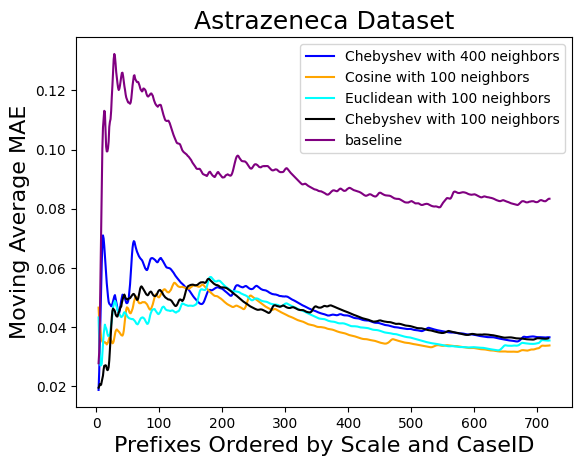

In [104]:
results_folder = 'results/Astrazeneca'  # Replace with the path to your results folder

# Get the list of files in the results folder
files = os.scandir(results_folder)
# Get scandir object
with os.scandir(results_folder) as entries:
    # Extract file names
    file_names = [entry.name for entry in entries if entry.is_file() & entry.name.endswith('.csv')]

# Print the file names as a string
print(file_names)

# Create a figure to display all the plots
# fig, ax = plt.subplots()
plt.figure()

# Loop through each file
for file in top_4_files:
    print(str(file))
    df = pd.read_csv(results_folder+"/"+file)
    df = df.tail(722)
    # df = df.sort_values(timestamp_col)
    
    # Plot the moving average MAE
    # Calculate the moving average
    window_size = 5
    moving_avg = calculate_moving_avg_mae(df, target_col, 'predicted_value')
    
    print(moving_avg.shape)
    # Plot the original values and the moving average
    label = filename_to_label.get(file, file)  # Get the custom label or default to filename
    if label == 'Cosine with 100 neighbors':
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='orange')
    elif label == 'Euclidean with 100 neighbors':
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='cyan')
    elif label == 'Chebyshev with 400 neighbors':
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='blue')
    elif label == 'Chebyshev with 100 neighbors':
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='black')
    else:
        plt.plot(moving_avg['moving_avg_mae'], label=label)
    plt.legend(fontsize='small')
  

    # Set the labels and title for the plot
    # ax.set_xlabel('Time')
    # ax.set_ylabel('Moving Average MAE')
    # ax.set_title('Moving Average MAE for Each File')
    # ax.legend()

    # Display the plot
baseline_results = baseline_results.sort_values([case_id_col,timestamp_col])
moving_avg_baseline = calculate_moving_avg_mae(baseline_results, target_col, 'predicted_value', window_size=5)
plt.plot(moving_avg_baseline['moving_avg_mae'], label='baseline', color='purple')
plt.legend(fontsize='medium')

# Set labels
plt.xlabel("Prefixes Ordered by Scale and CaseID", fontsize=16)
plt.ylabel("Moving Average MAE", fontsize=16)
plt.title("Astrazeneca Dataset", fontsize=18)
# plt.show()

# Save the figure in high quality
# plt.savefig('Astrazeneca.png', dpi=400)
plt.savefig('Astrazeneca.pdf', format='pdf')


In [96]:
tmp = pd.read_csv('results/Astrazeneca/Astra_Catboost_no_encoding_no_bucketing_100_cosine.csv')

In [97]:
# Calculate MAE
mae = mean_absolute_error(tmp["Target"], tmp["predicted_value"])

# Calculate MSE
mse = mean_squared_error(tmp["Target"], tmp["predicted_value"], squared=True)

# Calculate RMSE
rmse = mean_squared_error(tmp["Target"], tmp["predicted_value"], squared=False)

# Calculate R2
r2 = r2_score(tmp["Target"], tmp["predicted_value"])

# Calculate MAPE
mape = mean_absolute_percentage_error(tmp["Target"], tmp["predicted_value"])

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)
print("MAPE:", mape)

MAE: 0.03669120398049148
MSE: 0.004009154711336433
RMSE: 0.06331788618815724
R2: 0.9105603684048038
MAPE: 19831351778.71844


In [105]:
work_day_values = tmp[work_day_col].unique()
phases = ['lag', 'Exponential', 'plateau']
dat = pd.DataFrame(columns=['Working Day', 'MAE', 'MSE', 'RMSE'])
for phase in phases:
    if phase == 'lag':
        work_day_phase = work_day_values[:3]
    elif phase == 'Exponential':
        work_day_phase = work_day_values[3:6]
    else:
        work_day_phase = work_day_values[6:]
    work_day_data = tmp[tmp[work_day_col].isin(work_day_phase)]
    predicted_values = work_day_data['predicted_value']
    target_values = work_day_data['Target']
    
    mae = np.mean(np.abs(predicted_values - target_values))
    mse = np.mean((predicted_values - target_values) ** 2)
    rmse = np.sqrt(mse)
    
    new_row = pd.DataFrame({'Working Day': [phase], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
    dat = pd.concat([dat, new_row], ignore_index=True)
    
    print(f"Phase: {phase}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print()


Phase: lag
MAE: 0.010824891975161116
MSE: 0.0003375749055831583
RMSE: 0.018373211629520797

Phase: Exponential
MAE: 0.0202176306087692
MSE: 0.00086637710826562
RMSE: 0.029434284572002426

Phase: plateau
MAE: 0.0505342034402939
MSE: 0.006237104671266608
RMSE: 0.07897534217251995



/var/folders/sb/50cj9frx6576wh5j6rbpnb6c0000gp/T/ipykernel_92763/4137760266.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dat = pd.concat([dat, new_row], ignore_index=True)


In [106]:
work_day_values = baseline_results[work_day_col].unique()
phases = ['lag', 'Exponential', 'plateau']
dat2 = pd.DataFrame(columns=['Working Day', 'MAE', 'MSE', 'RMSE'])
for phase in phases:
    if phase == 'lag':
        work_day_phase = work_day_values[:3]
    elif phase == 'Exponential':
        work_day_phase = work_day_values[3:6]
    else:
        work_day_phase = work_day_values[6:]
    work_day_data = baseline_results[baseline_results[work_day_col].isin(work_day_phase)]
    predicted_values = work_day_data['predicted_value']
    target_values = work_day_data['Target']
    
    mae = np.mean(np.abs(predicted_values - target_values))
    mse = np.mean((predicted_values - target_values) ** 2)
    rmse = np.sqrt(mse)
    
    new_row = pd.DataFrame({'Working Day': [phase], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
    dat2 = pd.concat([dat2, new_row], ignore_index=True)
    
    print(f"Phase: {phase}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print()

Phase: lag
MAE: 0.027424783176072404
MSE: 0.0022523187031584344
RMSE: 0.047458599886200124

Phase: Exponential
MAE: 0.04637938055786771
MSE: 0.005270662322145694
RMSE: 0.07259932728438807

Phase: plateau
MAE: 0.11376334933116819
MSE: 0.025210810592756448
RMSE: 0.15877912517946574



/var/folders/sb/50cj9frx6576wh5j6rbpnb6c0000gp/T/ipykernel_92763/1578377656.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dat2 = pd.concat([dat2, new_row], ignore_index=True)


In [107]:
dat

,Working Day,MAE,MSE,RMSE
0,lag,0.010825,0.000338,0.018373
1,Exponential,0.020218,0.000866,0.029434
2,plateau,0.050534,0.006237,0.078975


In [108]:
dat2

,Working Day,MAE,MSE,RMSE
0,lag,0.027425,0.002252,0.047459
1,Exponential,0.046379,0.005271,0.072599
2,plateau,0.113763,0.025211,0.158779


In [ ]:
####################################################################################################

In [ ]:
results = []
method = 'Catboost'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
data['Target'] = data.groupby(case_id_col)['Target'].ffill().bfill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = split_data(data, train_ratio=0.5, split="temporal sim")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features


for index, row in current.iterrows():

    target = historic['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0, random_state=123)
        model.fit(historic[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    # true_conc_glu = row['Target_orig']
    # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    true_conc_glu = row['Target']
    preds_scaled = preds
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled
    })

In [ ]:
results_df = pd.DataFrame(results)
results_df

In [ ]:
# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/Astra_baseline_{method}_{config}_results.csv', index=False)

In [ ]:
results = []
method = 'Catboost'
# config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
config = 'encoding_bucketing'

data = dt_prefixes.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
# data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
# data['Target'] = data.groupby(case_id_col)['Target'].ffill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = split_data(data, train_ratio=0.5, split="temporal")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([timestamp_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features


for index, row in current.iterrows():

    target = historic['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0, random_state=123)
        model.fit(historic[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    true_conc_glu = row['Target_orig']
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled[0][0]
    })

In [ ]:
# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/baseline_{method}_{config}_results.csv', index=False)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential


# Ensure the data is sorted by case ID and workday
df_encoded = df_normalized.sort_values(by=[case_id_col, work_day_col])
df_encoded = df_encoded.drop([timestamp_col], axis=1)

# Function to create accumulated sequences
def create_accumulated_sequences(df):
    sequences = []
    for case_id, group in df.groupby(case_id_col):
        accumulated_data = []
        for i in range(len(group)):
            accumulated_data.append(group.iloc[:i+1].drop(columns=[case_id_col, work_day_col]).values.flatten())
            sequences.append(np.concatenate(accumulated_data))
    return sequences

# Create the accumulated sequences
sequences = create_accumulated_sequences(df_encoded)

# Pad the sequences to the same length
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

# Flatten the sequences to find unique tokens
flattened_sequences = np.concatenate(padded_sequences).flatten()

# Find unique tokens
unique_tokens = np.unique(flattened_sequences)

# Set vocab_size to the number of unique tokens plus one
vocab_size = len(unique_tokens) + 1
print(f"Vocabulary size: {vocab_size}")

# Define the embedding model
embedding_dim = 128  # Dimension of the embedding space
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
# Compile the model to avoid graph execution error
model.compile(optimizer='adam', loss='mse')
model.summary()

# Apply the embedding transformation
embedded_sequences = model.predict(padded_sequences)

In [ ]:
target_col = 'Viability (%)'

In [ ]:
df_normalized['Viability original'] = scalers[target_col].inverse_transform(df_normalized[target_col].to_numpy().reshape(-1, 1))

In [ ]:
# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df_cluster = pd.DataFrame(results)
results_df_cluster

In [ ]:
# Calculate metrics
true_values = results_df_cluster['true_value']
predicted_values = results_df_cluster['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df_baseline = pd.DataFrame(results)
results_df_baseline

In [ ]:
# Calculate metrics
true_values = results_df_baseline['true_value']
predicted_values = results_df_baseline['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df_baseline = pd.read_csv('results/Astra_Catboost_no_encoding_no_bucketing_cosine_results.csv')

In [ ]:
results_df = pd.read_csv('results/Astra_Catboost_no_encoding_no_bucketing_chebyshev_results.csv')

In [ ]:
results_df_cluster = pd.read_csv('results/Astra_Catboost_no_encoding_no_bucketing_results.csv')

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_baseline['row_data'])

# Drop the original row_data column from results_df_baseline
tmp = results_df_baseline.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp = pd.concat([tmp, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp = tmp[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df['row_data'])

# Drop the original row_data column from results_df_baseline
tmp2 = results_df.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp2 = pd.concat([tmp2, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp2 = tmp2[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_cluster['row_data'])

# Drop the original row_data column from results_df_baseline
tmp3 = results_df_cluster.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp3 = pd.concat([tmp3, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp3 = tmp3[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
results_df_100 = pd.read_csv('results/Astra_Catboost_no_encoding_no_bucketing_DTW_results.csv')

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_100['row_data'])

# Drop the original row_data column from results_df_baseline
tmp4 = results_df_100.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp4 = pd.concat([tmp4, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp4 = tmp4[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
def calculate_moving_avg_mae(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    mae_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        mae = mean_absolute_error(true_values[:i], predicted_values[:i])
        mae_list.append(mae)

    mae_df = pd.DataFrame({'num_rows': num_rows_list, 'mae': mae_list})
    mae_df['moving_avg_mae'] = mae_df['mae'].rolling(window=window_size).mean()
    
    return mae_df

# Calculate moving average MAE for tmp
mae_df_tmp = calculate_moving_avg_mae(tmp, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp2 = calculate_moving_avg_mae(tmp2, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp3 = calculate_moving_avg_mae(tmp3, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp4 = calculate_moving_avg_mae(tmp4, 'true_value', 'predicted_value')

# Plot the moving average MAE for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(mae_df_tmp['num_rows'], mae_df_tmp['moving_avg_mae'], label='cosine', color='blue')
plt.plot(mae_df_tmp2['num_rows'], mae_df_tmp2['moving_avg_mae'], label='levenstein', color='red')
plt.plot(mae_df_tmp3['num_rows'], mae_df_tmp3['moving_avg_mae'], label='euclidean', color='green')
plt.plot(mae_df_tmp4['num_rows'], mae_df_tmp4['moving_avg_mae'], label='DTW', color='black')
plt.xlabel('Number of Observed Rows')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average MAE')
plt.title('AstraZeneca')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def calculate_moving_avg_rmse(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    rmse_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        rmse = np.sqrt(mean_squared_error(true_values[:i], predicted_values[:i]))
        rmse_list.append(rmse)

    rmse_df = pd.DataFrame({'num_rows': num_rows_list, 'rmse': rmse_list})
    rmse_df['moving_avg_rmse'] = rmse_df['rmse'].rolling(window=window_size).mean()
    
    return rmse_df

# Calculate moving average RMSE for tmp
rmse_df_tmp = calculate_moving_avg_rmse(tmp, 'true_value', 'predicted_value')

# Calculate moving average RMSE for tmp2
rmse_df_tmp2 = calculate_moving_avg_rmse(tmp2, 'true_value', 'predicted_value')

# Plot the moving average RMSE for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(rmse_df_tmp['num_rows'], rmse_df_tmp['moving_avg_rmse'], label='regular learning', color='blue')
plt.plot(rmse_df_tmp2['num_rows'], rmse_df_tmp2['moving_avg_rmse'], label='just-in-time learning', color='red')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average RMSE')
plt.title('Moving Average RMSE vs Number of Observed events')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def calculate_moving_avg_r2(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    r2_list = []

    for i in range(10, len(true_values) + 1):
        num_rows_list.append(i)
        r2 = r2_score(true_values[:i], predicted_values[:i])
        r2_list.append(r2)

    r2_df = pd.DataFrame({'num_rows': num_rows_list, 'r2': r2_list})
    r2_df['moving_avg_r2'] = r2_df['r2'].rolling(window=window_size).mean()
    
    return r2_df

# Calculate moving average R² for tmp
r2_df_tmp = calculate_moving_avg_r2(tmp, 'true_value', 'predicted_value')

# Calculate moving average R² for tmp2
r2_df_tmp2 = calculate_moving_avg_r2(tmp2, 'true_value', 'predicted_value')

# Plot the moving average R² for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(r2_df_tmp['num_rows'], r2_df_tmp['moving_avg_r2'], label='regular learning', color='blue')
plt.plot(r2_df_tmp2['num_rows'], r2_df_tmp2['moving_avg_r2'], label='just-in-time learning', color='red')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average R²')
plt.title('Moving Average R² vs Number of Observed events')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def calculate_adjusted_r2(r2, n, k):
    if n <= k + 1:
        return np.nan  # Return NaN if the calculation is not possible
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

def calculate_moving_avg_adjusted_r2(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()
    k = 1  # Number of predictors

    num_rows_list = []
    adjusted_r2_list = []

    for i in range(10, len(true_values) + 1):
        num_rows_list.append(i)
        r2 = r2_score(true_values[:i], predicted_values[:i])
        adjusted_r2 = calculate_adjusted_r2(r2, i, k)
        adjusted_r2_list.append(adjusted_r2)

    adjusted_r2_df = pd.DataFrame({'num_rows': num_rows_list, 'adjusted_r2': adjusted_r2_list})
    adjusted_r2_df['moving_avg_adjusted_r2'] = adjusted_r2_df['adjusted_r2'].rolling(window=window_size).mean()
    
    return adjusted_r2_df

# Calculate moving average adjusted R² for tmp
adjusted_r2_df_tmp = calculate_moving_avg_adjusted_r2(tmp, 'true_value', 'predicted_value')

# Calculate moving average adjusted R² for tmp2
adjusted_r2_df_tmp2 = calculate_moving_avg_adjusted_r2(tmp2, 'true_value', 'predicted_value')

# Plot the moving average adjusted R² for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(adjusted_r2_df_tmp['num_rows'], adjusted_r2_df_tmp['moving_avg_adjusted_r2'], label='regular learning', color='blue')
plt.plot(adjusted_r2_df_tmp2['num_rows'], adjusted_r2_df_tmp2['moving_avg_adjusted_r2'], label='just-in-time learning', color='red')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average Adjusted R²')
plt.title('Moving Average Adjusted R² vs Number of Observed events')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
results = {}
method = 'Catboost'

data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data[target_col].shift(-1)
data['Target_orig'] = data['Titer (g/L) original'].shift(-1)

historic, current = split_data(data, train_ratio=0.5, split="temporal")




# df_train, df_test = split_data(data, split="loo", leave_out=[latest_case_id_col])


data = data.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
df_train = df_train.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
df_test = df_test.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)

df_without_last = df_train.groupby('UID').apply(remove_last_row).reset_index(drop=True)
df_without_last_test = df_test.groupby('UID').apply(remove_last_row).reset_index(drop=True)

target = df_without_last['Target'].values
# mask = np.isnan(target)
# target = target[~mask]

target_test = df_without_last_test['Target'].values
# mask = np.isnan(target_test)
# target_test = target_test[~mask]

if method == 'Catboost':
    # Create the CatBoostRegressor model
    model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
    model.fit(df_without_last[features+['Cluster']], target)

if method == 'HMM':
    # Create an instance of the HMM model
    model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
    model.fit(df_without_last[features+['Cluster']])

# Make predictions on the testing data
preds = model.predict(df_without_last_test[features+['Cluster']])

true_conc_glu = df_without_last_test['Target_orig'].to_numpy()
preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
# preds_scaled = np.expm1(preds)

results_folder = f'results_figures_{method}_rerun'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

plt.plot(true_conc_glu, label='True Values')
plt.plot(preds_scaled, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Titer (g/L)')
plt.title(f'True vs Predicted Titer for UID: {bioreactor}')
plt.legend()
plt.savefig(os.path.join(results_folder, f'{bioreactor}.png'))
plt.close()

MAE_t = mean_absolute_error(true_conc_glu, preds_scaled)
MSE_t = mean_squared_error(true_conc_glu, preds_scaled)
# RMSE_g = mean_squared_error(true_conc_glu, conc_glucose, squared=False)
RMSE_t = math.sqrt(MSE_t)
r2_t = r_squared = r2_score(true_conc_glu, preds_scaled)
mape_t = mean_absolute_percentage_error(true_conc_glu, preds_scaled)

results[bioreactor] = {'titer_MAE': MAE_t, 'titer_MSE': MSE_t, 'titer_RMSE':RMSE_t, 'titer_R2': r2_t, 'titer_MAPE': mape_t}

In [ ]:
df_results = pd.DataFrame(results).T
# catboost regular
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
df_results = pd.DataFrame(results).T
# catboost regular ـ old results with fewer experiments
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
df_results = pd.DataFrame(results).T
# HMM regular 
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
import shap

In [ ]:
import shap
import matplotlib.pyplot as plt

# Assuming you have a trained model named 'model' and a dataset named 'X'
explainer = shap.Explainer(model)
shap_values = explainer(df_train[features])

# Plot feature importances
plt.figure(figsize=(10, 20)) 
shap.summary_plot(shap_values, df_train[features], plot_type='bar', show=False)
plt.show()


In [ ]:
results = {}
method = 'Catboost'
for bioreactor in UIDs:
    data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
    data['Target'] = data[target_col].shift(-1)
    data['Target_orig'] = data['Titer (g/L) original'].shift(-1)
    data['Target_log'] = np.log1p(data['Target_orig']) 
    df_train, df_test = split_data(data, split="loo", leave_out=[bioreactor])

    
    data = data.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_train = df_train.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_test = df_test.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    
    df_without_last = df_train.groupby('UID').apply(remove_last_row).reset_index(drop=True)
    df_without_last_test = df_test.groupby('UID').apply(remove_last_row).reset_index(drop=True)

    target = df_without_last['Target_log'].values
    # mask = np.isnan(target)
    # target = target[~mask]

    target_test = df_without_last_test['Target_log'].values
    # mask = np.isnan(target_test)
    # target_test = target_test[~mask]
    
    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
        model.fit(df_without_last[features], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features])

    # Make predictions on the testing data
    preds = model.predict(df_without_last_test[features])

    true_conc_glu = df_without_last_test['Target_orig'].to_numpy()
    # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    preds_scaled = np.expm1(preds)

    results_folder = f'results_figures_{method}_log'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    plt.plot(true_conc_glu, label='True Values')
    plt.plot(preds_scaled, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Titer (g/L)')
    plt.title(f'True vs Predicted Titer for UID: {bioreactor}')
    plt.legend()
    plt.savefig(os.path.join(results_folder, f'{bioreactor}.png'))
    plt.close()
    
    MAE_t = mean_absolute_error(true_conc_glu, preds_scaled)
    MSE_t = mean_squared_error(true_conc_glu, preds_scaled)
    # RMSE_g = mean_squared_error(true_conc_glu, conc_glucose, squared=False)
    RMSE_t = math.sqrt(MSE_t)
    r2_t = r_squared = r2_score(true_conc_glu, preds_scaled)
    mape_t = mean_absolute_percentage_error(true_conc_glu, preds_scaled)

    results[bioreactor] = {'titer_MAE': MAE_t, 'titer_MSE': MSE_t, 'titer_RMSE':RMSE_t, 'titer_R2': r2_t, 'titer_MAPE': mape_t}

In [ ]:
df_results = pd.DataFrame(results).T
# catboost regular log
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
results = {}
method = 'Catboost'
for bioreactor in UIDs:
    data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
    data['Target'] = data[target_col].shift(-1)
    data['Target_orig'] = data['Titer (g/L) original'].shift(-1)
    # df['Target'] = df['Titer (g/L) original'].shift(-1)
    # df['Target_log'] = np.log1p(df['Target']) 
    df_train, df_test = split_data(data, split="loo", leave_out=[bioreactor])

    
    data = data.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_train = df_train.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_test = df_test.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    
    df_without_last = df_train.groupby('UID').apply(remove_last_row).reset_index(drop=True)
    df_without_last_test = df_test.groupby('UID').apply(remove_last_row).reset_index(drop=True)

    target = df_without_last['Target'].values
    # mask = np.isnan(target)
    # target = target[~mask]

    target_test = df_without_last_test['Target'].values
    # mask = np.isnan(target_test)
    # target_test = target_test[~mask]

    input_data = df_without_last[features].to_numpy().reshape(-1, 1, len(features))
    input_data_test = df_without_last_test[features].to_numpy().reshape(-1, 1, len(features))
    
    # Define LSTM model
    model = Sequential()
    # model.add(Embedding(input_dim=len(features), output_dim=50, input_length=max_sequence_len))
    model.add(LSTM(units=100))
    model.add(Dense(units=1, activation='relu'))  # Change the units to 1 for regression
    # model.build(input_shape=df_without_last[features].shape)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])  # Use mean squared error loss for regression
    
    #create checkpoint during training
    checkpoint_path = f"model_checkpoints/model_checkpoints_dataBricksTiter/training_without_{bioreactor}/cp.ckpt/checkpoint.weights.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    try:
        os.makedirs(checkpoint_dir, exist_ok=True)
    except FileExistsError:
        # directory already exists
        pass

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True, verbose=1)
    
    try:
        model.fit(input_data, target, epochs=50, callbacks=[cp_callback], verbose=2)
    except InvalidArgumentError as e:
        print(e)
        continue
    
    # Loads the weights
    model.load_weights(checkpoint_path)

    # Re-evaluate the model
    loss, acc = model.evaluate(input_data_test, target_test, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    
    with open('out.txt', 'a') as f:
        print("{}, accuracy: {:5.2f}%\n".format(bioreactor, (100 * acc)), file=f)

    preds = model.predict(input_data_test)

    true_conc_glu = df_without_last_test['Target_orig'].to_numpy()
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    # preds_scaled = np.expm1(preds)

    results_folder = f'results_figures_LSTM'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    plt.plot(true_conc_glu, label='True Values')
    plt.plot(preds_scaled, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Titer (g/L)')
    plt.title(f'True vs Predicted Titer for UID: {bioreactor}')
    plt.legend()
    plt.savefig(os.path.join(results_folder, f'{bioreactor}.png'))
    plt.close()
    
    MAE_t = mean_absolute_error(true_conc_glu, preds_scaled)
    MSE_t = mean_squared_error(true_conc_glu, preds_scaled)
    # RMSE_g = mean_squared_error(true_conc_glu, conc_glucose, squared=False)
    RMSE_t = math.sqrt(MSE_t)
    r2_t = r_squared = r2_score(true_conc_glu, preds_scaled)
    mape_t = mean_absolute_percentage_error(true_conc_glu, preds_scaled)

    results[bioreactor] = {'titer_MAE': MAE_t, 'titer_MSE': MSE_t, 'titer_RMSE':RMSE_t, 'titer_R2': r2_t, 'titer_MAPE': mape_t}


In [ ]:
df_results = pd.DataFrame(results).T
# lstm regular no sequence
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
results = {}
for bioreactor in UIDs:
    data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
    data['Target'] = data[target_col].shift(-1)
    data['Target_orig'] = data['Titer (g/L) original'].shift(-1)
    # df['Target'] = df['Titer (g/L) original'].shift(-1)
    # df['Target_log'] = np.log1p(df['Target']) 
    df_train, df_test = split_data(data, split="loo", leave_out=[bioreactor])

    
    data = data.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_train = df_train.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_test = df_test.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    
    # Group by 'UID' and concatenate values of 'value' column into a string
    sequences_all =data.groupby('UID').apply(lambda x: ' '.join(str(v) for v in x['Cluster'])).tolist()
    sequences = df_train.groupby('UID').apply(lambda x: ' '.join(str(v) for v in x['Cluster'])).tolist()
    sequences_test = df_test.groupby('UID').apply(lambda x: ' '.join(str(v) for v in x['Cluster'])).tolist()
    
    df_without_last = df_train.groupby('UID').apply(remove_last_row).reset_index(drop=True)
    df_without_last_test = df_test.groupby('UID').apply(remove_last_row).reset_index(drop=True)
    
    vocab_size, max_sequence_len = get_size_max_len(sequences_all)
    input_sequences, target_sequences = tokenize_and_pad(sequences, max_sequence_len)
    input_sequences_test, target_sequences_test = tokenize_and_pad(sequences_test, max_sequence_len)

    target = df_without_last['Target'].values
    # mask = np.isnan(target)
    # target = target[~mask]

    target_test = df_without_last_test['Target'].values
    # mask = np.isnan(target_test)
    # target_test = target_test[~mask]
    
    # Define LSTM model
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_sequence_len))
    model.add(LSTM(units=100))
    model.add(Dense(units=1, activation='relu'))  # Change the units to 1 for regression
    # model.build(input_shape=df_without_last[features].shape)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])  # Use mean squared error loss for regression
    
    #create checkpoint during training
    checkpoint_path = f"model_checkpoints/model_checkpoints_dataBricksTiterCluster/training_without_{bioreactor}/cp.ckpt/checkpoint.weights.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    try:
        os.makedirs(checkpoint_dir, exist_ok=True)
    except FileExistsError:
        # directory already exists
        pass

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True, verbose=1)
    
    try:
        model.fit(input_sequences, target, epochs=50, callbacks=[cp_callback], verbose=2)
    except InvalidArgumentError as e:
        print(e)
        continue
    
    # Loads the weights
    model.load_weights(checkpoint_path)

    # Re-evaluate the model
    loss, acc = model.evaluate(input_sequences_test, target_test, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    
    with open('out.txt', 'a') as f:
        print("{}, accuracy: {:5.2f}%\n".format(bioreactor, (100 * acc)), file=f)

    preds = model.predict(input_sequences_test)

    true_conc_glu = df_without_last_test['Target_orig'].to_numpy()
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    # preds_scaled = np.expm1(preds)

    results_folder = f'results_figures_LSTM_cluster'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    plt.plot(true_conc_glu, label='True Values')
    plt.plot(preds_scaled, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Titer (g/L)')
    plt.title(f'True vs Predicted Titer for UID: {bioreactor}')
    plt.legend()
    plt.savefig(os.path.join(results_folder, f'{bioreactor}.png'))
    plt.close()
    
    MAE_t = mean_absolute_error(true_conc_glu, preds_scaled)
    MSE_t = mean_squared_error(true_conc_glu, preds_scaled)
    # RMSE_g = mean_squared_error(true_conc_glu, conc_glucose, squared=False)
    RMSE_t = math.sqrt(MSE_t)
    r2_t = r_squared = r2_score(true_conc_glu, preds_scaled)
    mape_t = mean_absolute_percentage_error(true_conc_glu, preds_scaled)

    results[bioreactor] = {'titer_MAE': MAE_t, 'titer_MSE': MSE_t, 'titer_RMSE':RMSE_t, 'titer_R2': r2_t, 'titer_MAPE': mape_t}

In [ ]:
df_results = pd.DataFrame(results).T
# lstm regular cluster sequence
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create the model
model = Sequential()

# Add the convolutional layer
model.add(Conv2D(5, (3, 3), strides=(1, 1), padding='valid', activation='relu', input_shape=(10, 10, 1)))

# Add the max pooling layer
model.add(MaxPooling2D(pool_size=(4, 4), strides=(1, 1), padding='valid'))

# Flatten the output from the previous layer
model.add(Flatten())

# Add the fully connected layer
model.add(Dense(6, activation='relu'))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


In [ ]:
model = Sequential()
model.add(Conv2D(input_dim=10, kernel_size=3, strrides=1, padding='None'))
model.add(MaxPool2D(units=100))
model.add(Dense(units=1, activation='relu'))